In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import FormatStrFormatter
import matplotlib.patches as mpatches
import math

# width = 505.89
width = 417.68646

proto_labels = np.array(["OTS","PQ-OTS","SC"])
lotto_labels = np.array(["Tournament","OTS", "OTS (w/ batching)", "PQ-OTS", "PQ-OTS (w/ batching)"])

ots_labels = ["cl_wr", "ac_wr", "ac_r", "decrypt", "recover"]
pq_labels = ["cl_wr", "verify_wr", "ac_wr", "ac_r", "decrypt", "recover"]

ots_ll = ["Write (Client)", "Write (AC)", "Read (AC)", "Secret reconstruction (Client)", "Share retrieval (SM)"]
pq_ll = ["Write (Client)", "Confirm write (SM)", "Write (AC)", "Read (AC)", "Secret reconstruction (Client)", "Share retrieval (SM)"]

cmt_sizes = np.array([16,32,64,128])
txn_counts = np.array([4,8,16,32,64,128,160,192])

In [4]:
def set_size(width, fraction=1):
    """ Set aesthetic figure dimensions to avoid scaling in latex.
    Parameters
    ----------
    width: float
            Width in pts
    fraction: float
            Fraction of the width which you wish the figure to occupy
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

In [ ]:
def plot_burst(in_paths, out_path, txn_type):
#     colors = ['#CB225F','#3A86BD','#C3753C']
#     colors = ['#892EB1','#40993F','#CA7E35']
    colors = ['darkorchid','forestgreen','#DC7A23']
    fig, ax = plt.subplots(1,1,figsize=set_size(width, fraction=1))

    input_data = list()
    y_values = list()
    for i in range(len(in_paths)):
        input_data.append(pd.read_csv(in_paths[i]))
        y_values.append(input_data[i]['avg'].tolist())

    for i in range(len(y_values)):
        ax.plot(txn_counts, y_values[i], marker='x', color=colors[i])
    
    plt.xscale('log')
    plt.yscale('log')
    plt.xticks(txn_counts, txn_counts, fontsize=12, rotation=45)

    if txn_type == 'w':
#         plt.xlabel("Number of write transactions", fontsize=12)
#         plt.title("Write workflow")
        plt.yticks(fontsize=12)
        plt.ylim((0,200))
#         new_yts = [10,100]
#         plt.yticks(new_yts, new_yts, fontsize=12)
    else:
#         plt.xlabel("Number of read transactions", fontsize=12)
#         plt.title("Read workflow", fontsize=12)
        plt.yticks(fontsize=12)
        plt.ylim((0,300))
#         new_yts = [10,100,1000]
#         plt.yticks(new_yts, new_yts, fontsize=12)
    
    plt.xlabel("Number of concurrent users", fontsize=12)
    plt.ylabel("Latency (s)", fontsize=12)
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
    plt.legend(proto_labels.astype(str), fontsize=12, title_fontsize=12, ncol=1)

    plt.grid(linestyle='--', color='silver', axis='y', linewidth=0.5)
    plt.savefig(out_path, bbox_inches='tight', format='pdf')
    
    print(y_values)

In [ ]:
write_paths = ['./data/burst/ots_w.csv','./data/burst/pqots_w.csv','./data/burst/sc_w.csv']
read_paths = ['./data/burst/ots_r.csv','./data/burst/pqots_r.csv','./data/burst/sc_r.csv']

plot_burst(write_paths, "./plots/burst_write.pdf", "w")
plot_burst(read_paths, "./plots/burst_read.pdf", "r")

In [ ]:
def plot_lotto(input_files, output_path):
    colors = ['darkorange','darkorchid', '#CE92DD', 'forestgreen', 'darkseagreen']
    fig, ax = plt.subplots(1,1,figsize=set_size(width, fraction=1))

    input_data = list()
    x = np.arange(1,16,1)
    y_values = list()
    for i in range(len(input_files)):
        input_data.append(pd.read_csv(input_files[i]))
        y_values.append(input_data[i]['avg'].tolist())
           
    for i in range(len(y_values)):
        ax.plot(x, y_values[i], marker='x', color=colors[i])
        
    plt.xticks(x, x, fontsize=12)
    plt.xlabel("Day", fontsize=12)
    plt.yticks(fontsize=12)
    
    yts = ax.get_yticks().astype(np.int64)
    plt.ylim([yts[0],yts[-2]])

    plt.ylabel("Latency (s)", fontsize=12)
    plt.legend(lotto_labels.astype(str), fontsize=12, title_fontsize=12, ncol=2, bbox_to_anchor=(1.04,1.36))
#     plt.legend(lotto_labels.astype(str), fontsize=12, title_fontsize=12, ncol=1, bbox_to_anchor=(1,0.75))

    plt.grid(linestyle='--', color='silver', axis='y', linewidth=0.5)
    plt.savefig(output_path, bbox_inches='tight', format='pdf')

In [ ]:
in_paths = ['./data/lotto/tournament.csv','./data/lotto/ots.csv','./data/lotto/pqots.csv','./data/lotto/ots_batch.csv','./data/lotto/pqots_batch.csv']

plot_lotto(in_paths, "./plots/lotto.pdf")

In [ ]:
def plot_micro(in_path, proto):
    w = 0.1
    colors = ['#2B8D8F', '#a6e3e4','#ffdc93', 'crimson', '#FFC8D2', '#40ced1']
    fig, ax = plt.subplots(1,1,figsize=set_size(width, fraction=1))

    input_data = pd.read_csv(in_path)
    x = np.arange(len(cmt_sizes))
    y_values = dict()

    if proto == "ots":
        for lbl in ots_labels:
            if lbl != "verify_wr":
                y_values[lbl] = input_data[lbl].tolist()    
        ax.bar(x-w, y_values[ots_labels[0]], w, color=colors[0])
        ax.bar(x-w, y_values[ots_labels[1]], w, bottom = y_values[ots_labels[0]], color=colors[1])
        ax.bar(x, y_values[ots_labels[2]], w, color=colors[2])
        ax.bar(x+w, y_values[ots_labels[4]], w, color=colors[3])
        ax.bar(x+w, y_values[ots_labels[3]], w, bottom = y_values[ots_labels[4]], color=colors[4])
        plt.legend(ots_ll, ncol=2, bbox_to_anchor=(0.5,1.28), loc="upper center")
        plt.ylim((0.01,20))
        print(y_values)
    else:
        for lbl in pq_labels:
            y_values[lbl] = input_data[lbl].tolist()
        ax.bar(x-w, y_values[pq_labels[0]], w, color=colors[0])
        ax.bar(x-w, y_values[pq_labels[1]], w, bottom = y_values[pq_labels[0]], color=colors[5])
        ax.bar(x-w, y_values[pq_labels[2]], w, bottom = y_values[pq_labels[1]], color=colors[1])
        ax.bar(x, y_values[pq_labels[3]], w, color=colors[2])
        ax.bar(x+w, y_values[pq_labels[5]], w, color=colors[3])
        ax.bar(x+w, y_values[pq_labels[4]], w, bottom = y_values[pq_labels[5]], color=colors[4])
        print(y_values)
#         plt.ylim([0.0001,15])
        plt.ylim((0.001,20))
        plt.legend(pq_ll, ncol=2, bbox_to_anchor=(0.5,1.28), loc="upper center")
        
    plt.xticks(x, cmt_sizes, fontsize=12)
    plt.yticks(fontsize=12)
    plt.yscale('log')
    plt.xlabel("Committee size", fontsize=12)
    plt.ylabel("Latency (s)", fontsize=12)
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
    plt.grid(linestyle='--', color='silver', axis='y', linewidth=0.5)
    fname = f'{proto}_micro.pdf'
    plt.savefig(os.path.join('./plots', fname), bbox_inches='tight', format='pdf')

In [ ]:
in_paths = ['./data/micro/ots.csv','./data/micro/pqots.csv']

plot_micro(in_paths[0], "ots")
plot_micro(in_paths[1], "pqots")

In [5]:
def plot_byzgen(base_dir):
    w = 0.1
    colors = ['#f1c07a','#ab84bb','#84bb8c']
    fig, ax = plt.subplots(1,1,figsize=set_size(width, fraction=1))

    x = np.arange(2)    
    ys = list()
    protos = ["sc", "ots", "pqots"]
    for p in protos:
        vals = list()
        input_data = pd.read_csv(os.path.join(base_dir, f'{p}_write.csv'))
        vals.append(input_data.loc[0,"avg"])
        input_data = pd.read_csv(os.path.join(base_dir, f'{p}_read.csv'))
        vals.append(input_data.loc[0,"avg"])
        ys.append(vals)

    print(ys)
    ax.bar(x-w, ys[0], w, color=colors[0])
    ax.bar(x, ys[1], w, color=colors[1])
    ax.bar(x+w, ys[2], w, color=colors[2])
    
    plt.xticks(x, ["Write", "Read"], fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel("Workflow type", fontsize=12)
    plt.ylabel("Latency (s)", fontsize=12)
               
    plt.legend(["SC","OTS","PQ-OTS"], ncol=1, loc="upper center", fontsize=12)
    plt.grid(linestyle='--', color='silver', axis='y', linewidth=0.5)
    plt.savefig('./plots/byzgen.pdf', bbox_inches='tight', format='pdf')

[[6.037287132344866, 6.241957459863946], [7.610021022515101, 7.545976033333334], [7.369710081274025, 7.397762895918368]]


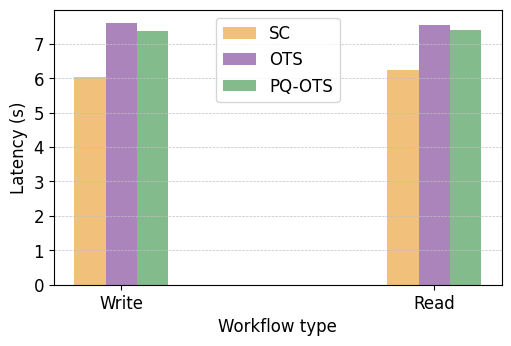

In [6]:
plot_byzgen("./data/byzgen")